In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, roc_curve, auc 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, RFECV, RFE, SelectKBest, f_classif
from scipy.stats import randint
from sklearn.model_selection import StratifiedKFold, KFold
from string import ascii_lowercase


In [31]:

orchard = 'Pistachio'
main = pd.read_json('../results_cleaned/mdf_all.json')
main = main.dropna(how='any',axis=0) 
main.info()
mdf = main.iloc[:,2:-1]
n_total = mdf.shape[0]
mdf
# mdf.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 125
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tree_idx     126 non-null    int64  
 1   test_number  126 non-null    object 
 2   T_min        126 non-null    float64
 3   T_mean       126 non-null    float64
 4   T_max        126 non-null    float64
 5   P_min        126 non-null    float64
 6   P_mean       126 non-null    float64
 7   P_max        126 non-null    float64
 8   RH_min       126 non-null    float64
 9   RH_mean      126 non-null    float64
 10  RH_max       126 non-null    float64
 11  CWSI         126 non-null    float64
 12  NDVI         126 non-null    float64
 13  GNDVI        126 non-null    float64
 14  OSAVI        126 non-null    float64
 15  LCI          126 non-null    float64
 16  NDRE         126 non-null    float64
 17  SWP          126 non-null    float64
 18  SWPc         126 non-null    object 
dtypes: float

,T_min,T_mean,T_max,P_min,P_mean,P_max,RH_min,RH_mean,RH_max,CWSI,NDVI,GNDVI,OSAVI,LCI,NDRE,SWP
0,13.52,25.526825,36.33,1003.92,1005.561111,1006.95,13.85,41.647302,72.19,0.137931,0.651247,0.579653,0.311467,0.224935,0.157902,6.7
1,13.52,25.526825,36.33,1003.92,1005.561111,1006.95,13.85,41.647302,72.19,0.000000,0.727823,0.628124,0.339363,0.256596,0.174475,8.7
2,13.52,25.526825,36.33,1003.92,1005.561111,1006.95,13.85,41.647302,72.19,0.048276,0.731136,0.633427,0.348855,0.272154,0.187457,6.0
3,13.52,25.526825,36.33,1003.92,1005.561111,1006.95,13.85,41.647302,72.19,0.227586,0.705379,0.588299,0.368542,0.211414,0.142261,5.7
4,13.52,25.526825,36.33,1003.92,1005.561111,1006.95,13.85,41.647302,72.19,0.206897,0.745715,0.642535,0.393172,0.275420,0.187919,5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,15.01,27.919194,39.09,1006.07,1008.034839,1009.75,20.12,38.995645,71.59,0.434483,0.651964,0.578798,0.306616,0.242141,0.172492,13.2
122,15.01,27.919194,39.09,1006.07,1008.034839,1009.75,20.12,38.995645,71.59,0.717241,0.613730,0.552401,0.294611,0.227958,0.164832,11.3
123,15.01,27.919194,39.09,1006.07,1008.034839,1009.75,20.12,38.995645,71.59,0.531034,0.675721,0.584211,0.332427,0.246689,0.173681,9.8
124,15.01,27.919194,39.09,1006.07,1008.034839,1009.75,20.12,38.995645,71.59,0.544828,0.667222,0.585880,0.325666,0.247613,0.174950,8.5


In [32]:
corrs = mdf.corr()
# print(corrs)
print(corrs['SWP'].sort_values(ascending=False),'\n')

SWP        1.000000
P_min      0.721520
P_max      0.676054
P_mean     0.644681
T_mean     0.483994
T_min      0.411512
T_max      0.388690
CWSI       0.353805
NDRE       0.282550
RH_min     0.222965
LCI        0.143585
RH_mean    0.002418
RH_max    -0.177669
GNDVI     -0.320667
NDVI      -0.449016
OSAVI     -0.508368
Name: SWP, dtype: float64 



Correlation Heatmaps

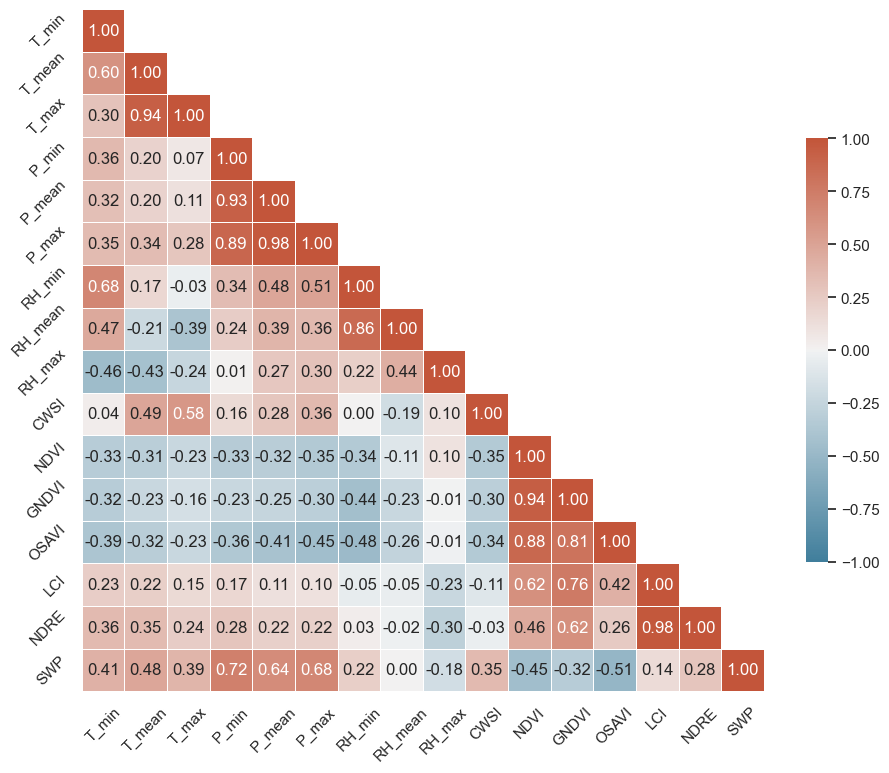

In [33]:
f , ax = plt.subplots(figsize=(11,11),dpi=100)  # increased the size for better readability
mask = np.triu(np.ones_like(corrs, dtype=bool), k=1)
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # color palette
sns.heatmap(corrs,mask=mask, square=True, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# plt.title(orchard + ': Correlation Heatmap', fontsize=20)  # title of the heatmap
# plt.xlabel('Variables', fontsize=15)  # x-axis label
# plt.ylabel('Variables', fontsize=15)  # y-axis label

plt.xticks(rotation=45)  # rotate x-axis labels if needed
plt.yticks(rotation=45)  # rotate y-axis labels if needed

plt.savefig('../figures/'+orchard+'_correlation.png',dpi=600)
plt.show()


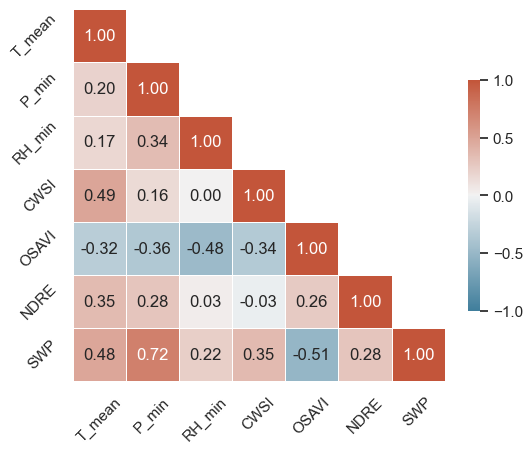

In [34]:
# # mdf = mdf.drop(['LCI','NDVI','GNDVI', 'leaf_temp','OSAVI'], axis=1)
mdf = mdf.drop(['LCI', 'GNDVI' ,'NDVI' ,'P_max','P_mean','RH_mean','RH_max','T_min','T_max'], axis=1)
corrs = mdf.corr()
# f , ax = plt.subplots(figsize=(5,5))
# sns.heatmap(corrs,square=True,vmax=1)
f , ax = plt.subplots(figsize=(6,6),dpi=100)  # increased the size for better readability
mask = np.triu(np.ones_like(corrs, dtype=bool), k=1)
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # color palette
sns.heatmap(corrs,mask=mask, square=True, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# plt.title(orchard+ ': Correlation Heatmap (Reduced)', fontsize=19)  # title of the heatmap
# plt.xlabel('Variables', fontsize=15)  # x-axis label
# plt.ylabel('Variables', fontsize=15)  # y-axis label 

plt.xticks(rotation=45)  # rotate x-axis labels if needed
plt.yticks(rotation=45)  # rotate y-axis labels if needed


plt.savefig('../figures/'+orchard+'_correlation_r.png',dpi=600)
plt.show()

In [35]:
cuttoff = 9
bins = (0,cuttoff)
label_quality = LabelEncoder()
# group_names = ['WL1','WL2']
main['SWPc2'] = pd.cut(main['SWP'], bins=bins)
main['SWPc2'] = label_quality.fit_transform(main['SWPc2'])
main['SWPc2'].isnull().sum() 

0

In [36]:
mdf

,T_mean,P_min,RH_min,CWSI,OSAVI,NDRE,SWP
0,25.526825,1003.92,13.85,0.137931,0.311467,0.157902,6.7
1,25.526825,1003.92,13.85,0.000000,0.339363,0.174475,8.7
2,25.526825,1003.92,13.85,0.048276,0.348855,0.187457,6.0
3,25.526825,1003.92,13.85,0.227586,0.368542,0.142261,5.7
4,25.526825,1003.92,13.85,0.206897,0.393172,0.187919,5.2
...,...,...,...,...,...,...,...
121,27.919194,1006.07,20.12,0.434483,0.306616,0.172492,13.2
122,27.919194,1006.07,20.12,0.717241,0.294611,0.164832,11.3
123,27.919194,1006.07,20.12,0.531034,0.332427,0.173681,9.8
124,27.919194,1006.07,20.12,0.544828,0.325666,0.174950,8.5


Dataset split

In [37]:
X = mdf.drop('SWP',axis=1)
y = main['SWPc2']
test_size = 0.25
num_features_to_select = 6
cv=10

skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=13)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, \
                                                    random_state = 15)

feature_names = mdf.columns[:-1].to_numpy() 



 SWPc2 
 0    89
1    37
Name: SWPc2, dtype: int64

 Test data set 
 0    18
1    14
Name: SWPc2, dtype: int64


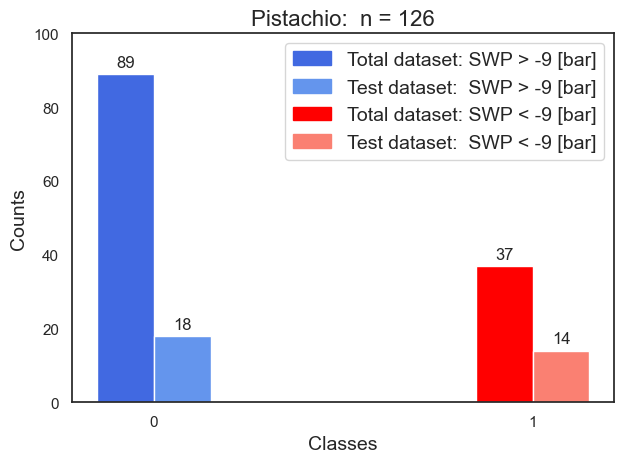

In [54]:
print('\n SWPc2 \n',main['SWPc2'].value_counts())
print('\n Test data set \n',y_test.value_counts())

def plot_label_distribution(main, y_test):
    # Calculate the frequencies for each category in the total and test datasets
    total_counts = main['SWPc2'].value_counts().sort_index()
    test_counts = y_test.value_counts().sort_index()

    # Define the labels for the plot (assuming the categories are 0 and 1)
    mylabels = total_counts.index

    x = np.arange(len(mylabels))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots()

    rects1 = ax.bar(x - width/2, total_counts, width, label='Total', color=['royalblue' if label == 0 else 'red' for label in mylabels])
    rects2 = ax.bar(x + width/2, test_counts, width, label='Test', color=['cornflowerblue' if label == 0 else 'salmon' for label in mylabels])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts',fontsize=14)
    ax.set_title(orchard+':  n = '+str(n_total),fontsize=16)
    ax.set_xlabel('Classes',fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(mylabels)
    ax.set_ylim([0, 100])
    # ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.grid(False)


    tot0 = mpatches.Patch(color='royalblue', label=f'Total dataset: SWP > {-cuttoff} [bar]')
    test0 = mpatches.Patch(color='cornflowerblue', label=f'Test dataset:  SWP > {-cuttoff} [bar]')
    tot1 = mpatches.Patch(color='red', label=f'Total dataset: SWP < {-cuttoff} [bar]')
    test1 = mpatches.Patch(color='salmon', label=f'Test dataset:  SWP < {-cuttoff} [bar]')
    plt.legend(handles=[tot0,test0,tot1,test1], fontsize=14, loc='upper right')
    # plt.legend('s','2','3','5')
    
    plt.savefig('../figures/'+orchard+'_counts.png', dpi=300)
    plt.show()
    
plot_label_distribution(main, y_test)

-Random Forest

In [55]:
############ Hyperparameter optimization RandomizedCV and RFECV  ############
rf_param_grid = {
    'clf__n_estimators': randint(10, 700),
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth': randint(1, 5),
    'clf__criterion': ['gini', 'entropy']
}

pipe_rfc = Pipeline([
    ('scaler', StandardScaler()),
    # ('selector', RFECV(estimator=RandomForestClassifier(), step=1, cv=5)),
    ('selector', RFE(estimator=RandomForestClassifier(), n_features_to_select=num_features_to_select)),
    ('clf', RandomForestClassifier())
])

# Initialize RandomizedSearchCV
grid_search_rfc = RandomizedSearchCV(estimator=pipe_rfc, param_distributions=rf_param_grid, cv=skf, n_jobs=-1, verbose=2)

# Fit to the data
grid_search_rfc.fit(X_train, y_train)

# Extract best estimator
best_rfc = grid_search_rfc.best_estimator_

# Predict using best estimator
pred_rfc = best_rfc.predict(X_test)

# Get the best features
print("Current available features: ",feature_names)
rf_support = best_rfc.named_steps['selector'].support_
rf_feature = feature_names[rf_support]
print("Best features for RandomForest: ", rf_feature)

# Get feature importances (rankings)
importances = best_rfc.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking for selected features
print("Feature ranking for selected features:")

for f in range(sum(rf_support)):
    print("%d. feature %s (%f)" % (f + 1, rf_feature[indices[f]], importances[indices[f]]))
    
print("\n Best Parameters for RF:",grid_search_rfc.best_params_)

rfc = best_rfc
print('\n Random Forest accuracy: ',accuracy_score(y_test, pred_rfc))
print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Current available features:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']
Best features for RandomForest:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']
Feature ranking for selected features:
1. feature P_min (0.299251)
2. feature CWSI (0.221654)
3. feature OSAVI (0.200466)
4. feature NDRE (0.112417)
5. feature RH_min (0.101262)
6. feature T_mean (0.064950)

 Best Parameters for RF: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__max_features': 'log2', 'clf__n_estimators': 329}

 Random Forest accuracy:  0.875
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.92      0.79      0.85        14

    accuracy                           0.88        32
   macro avg       0.88      0.87      0.87        32
weighted avg       0.88      0.88      0.87        32

[[17  1]
 [ 3 11]]


Support Vector Machine

In [56]:
# Setup the pipeline steps
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif, k=num_features_to_select)),  
    ('svc', SVC(probability=True))
])

# Define a grid of hyperparameters
svc_param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize GridSearchCV
grid_search_svc = GridSearchCV(estimator=pipe_svc, param_grid=svc_param_grid, cv=skf, n_jobs=-1, verbose=2)

# Fit to the data
grid_search_svc.fit(X_train, y_train)

# Extract the best estimator
best_svc = grid_search_svc.best_estimator_

# Predict using the best estimator
pred_svc = best_svc.predict(X_test)

print("Current available features: ", feature_names)
svc_support = best_svc.named_steps['selector'].get_support()
svc_feature = feature_names[svc_support]
print("Selected features for SVC: ", svc_feature)

svc = best_svc
print('\n Best Parameters for SVC:',grid_search_svc.best_params_)
print('\n SVM accuracy: ',accuracy_score(y_test, pred_svc))
print(classification_report(y_test, pred_svc))
print(confusion_matrix(y_test, pred_svc))

# svc=SVC()
# svc.fit(X_train,y_train)
# pred_svc = svc.predict(X_test)
# print('SVM accuracy: ',accuracy_score(y_test, pred_svc))
# print(classification_report(y_test, pred_svc))
# print(confusion_matrix(y_test, pred_svc))

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Current available features:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']
Selected features for SVC:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']

 Best Parameters for SVC: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}

 SVM accuracy:  0.8125
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        18
           1       0.83      0.71      0.77        14

    accuracy                           0.81        32
   macro avg       0.82      0.80      0.81        32
weighted avg       0.81      0.81      0.81        32

[[16  2]
 [ 4 10]]


Gaussian NB

In [57]:
pipe_gnb = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif, k=num_features_to_select)),  
    ('gnb', GaussianNB())
])

# Fit to the data
pipe_gnb.fit(X_train, y_train)

# Predict using the pipeline
pred_gnb = pipe_gnb.predict(X_test)

print("Current available features: ", feature_names)
gnb_support = pipe_gnb.named_steps['selector'].get_support()
gnb_feature = feature_names[gnb_support]
print("Selected features for GaussianNB: ", gnb_feature)


gnb = pipe_gnb
print('\n GaussianNB accuracy: ',accuracy_score(y_test, pred_gnb))
print(classification_report(y_test, pred_gnb))
print(confusion_matrix(y_test, pred_gnb))


# gnb= GaussianNB()
# gnb.fit(X_train,y_train)
# pred_gnb = gnb.predict(X_test)
# print('GaussianNB accuracy: ',accuracy_score(y_test, pred_gnb))
# print(classification_report(y_test, pred_gnb))
# print(confusion_matrix(y_test, pred_gnb))

Current available features:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']
Selected features for GaussianNB:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']

 GaussianNB accuracy:  0.84375
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.85      0.79      0.81        14

    accuracy                           0.84        32
   macro avg       0.84      0.84      0.84        32
weighted avg       0.84      0.84      0.84        32

[[16  2]
 [ 3 11]]


Decision Tree

In [58]:

# Define parameter grid for DecisionTree
dt_param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': randint(1, 5),
    'clf__min_samples_split': randint(2, 10),
    'clf__min_samples_leaf': randint(1, 5)
}

pipe_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif, k=num_features_to_select)),  
    ('clf', tree.DecisionTreeClassifier())
])

# Initialize RandomizedSearchCV
grid_search_dt = RandomizedSearchCV(estimator=pipe_dt, param_distributions=dt_param_grid, cv=skf, n_jobs=-1, verbose=2)

# Fit to the data
grid_search_dt.fit(X_train, y_train)

# Extract the best estimator
best_dt = grid_search_dt.best_estimator_

# Predict using the best estimator
pred_dt = best_dt.predict(X_test)

print("Current available features: ", feature_names)
dt_support = best_dt.named_steps['selector'].get_support()
dt_feature = feature_names[dt_support]
print("Selected features for DecisionTreeClassifier: ", dt_feature)

dt = best_dt
print("\n Best Parameters for DecisionTree:",grid_search_dt.best_params_)
print('\n Decision Tree accuracy: ',accuracy_score(y_test, pred_dt))
print(classification_report(y_test, pred_dt))
print(confusion_matrix(y_test, pred_dt))


# dt= tree.DecisionTreeClassifier()
# dt.fit(X_train,y_train)
# pred_dt = dt.predict(X_test)
# print('DT accuracy: ',accuracy_score(y_test, pred_dt))
# print(classification_report(y_test, pred_dt))
# print(confusion_matrix(y_test, pred_dt))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Current available features:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']
Selected features for DecisionTreeClassifier:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']

 Best Parameters for DecisionTree: {'clf__criterion': 'entropy', 'clf__max_depth': 2, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 6}

 Decision Tree accuracy:  0.875
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.92      0.79      0.85        14

    accuracy                           0.88        32
   macro avg       0.88      0.87      0.87        32
weighted avg       0.88      0.88      0.87        32

[[17  1]
 [ 3 11]]


K Nearest Neibour

In [59]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif, k=num_features_to_select)),  # Univariate feature selection
    ('knn', KNeighborsClassifier())
])

# Define a random grid of hyperparameters
knn_param_grid = {
    'knn__n_neighbors': randint(1, 20),  # Random integer between 1 and 20
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize RandomizedSearchCV
grid_search_knn = RandomizedSearchCV(estimator=pipe_knn, param_distributions=knn_param_grid, cv=skf, n_jobs=-1, verbose=2)

# Fit to the data
grid_search_knn.fit(X_train, y_train)

# Extract the best estimator
best_knn = grid_search_knn.best_estimator_

# Predict using the best estimator
pred_knn = best_knn.predict(X_test)

print("Current available features: ", feature_names)
knn_support = best_knn.named_steps['selector'].get_support()
knn_feature = feature_names[knn_support]
print("Selected features for KNeighborsClassifier: ", knn_feature)

knn = best_knn
print("\nBest Parameters for KNN:", grid_search_knn.best_params_)
print('\n KNN accuracy: ', accuracy_score(y_test, pred_knn))
print(classification_report(y_test, pred_knn))
print(confusion_matrix(y_test, pred_knn))

# knn= KNeighborsClassifier(n_neighbors=3)
# knn.fit(X_train,y_train)
# pred_knn = knn.predict(X_test)
# print('KNN accuracy: ',accuracy_score(y_test, pred_knn))
# print(classification_report(y_test, pred_knn))
# print(confusion_matrix(y_test, pred_knn))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Current available features:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']
Selected features for KNeighborsClassifier:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']

Best Parameters for KNN: {'knn__metric': 'euclidean', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}

 KNN accuracy:  0.84375
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.85      0.79      0.81        14

    accuracy                           0.84        32
   macro avg       0.84      0.84      0.84        32
weighted avg       0.84      0.84      0.84        32

[[16  2]
 [ 3 11]]


Artificial Neural Network

In [60]:
# Setup the pipeline steps
pipe_mlpc = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif, k=num_features_to_select)),  # Univariate feature selection
    ('mlp', MLPClassifier(max_iter=2000))
])

# Define a random grid of hyperparameters
mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(randint.rvs(5, 20), randint.rvs(5, 20)) for _ in range(10)],  # 10 random combinations
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.0001, 0.05],
    'mlp__learning_rate': ['constant', 'adaptive'],
}

# Initialize RandomizedSearchCV
grid_search_mlp = RandomizedSearchCV(estimator=pipe_mlpc, param_distributions=mlp_param_grid, cv=skf, n_jobs=-1, verbose=2)

# Fit to the data
grid_search_mlp.fit(X_train, y_train)

# Extract the best estimator
best_mlp = grid_search_mlp.best_estimator_

# Predict using the best estimator
pred_mlp = best_mlp.predict(X_test)

print("Current available features: ", feature_names)
mlp_support = best_mlp.named_steps['selector'].get_support()
mlp_feature = feature_names[mlp_support]
print("Selected features for MLPClassifier: ", mlp_feature)

# nn_probs = best_mlp.predict_proba(X_test)
# nn_probs = nn_probs[:, 1]
# nn_auc = roc_auc_score(y_test, nn_probs)
# print('Neural Network: ROC AUC=%.3f' % (nn_auc))


mlpc = best_mlp
print("\n Best Parameters for MLP:",grid_search_mlp.best_params_)
print('\n Neural Network accuracy: ',accuracy_score(y_test, pred_mlp))
print(classification_report(y_test, pred_mlp))
print(confusion_matrix(y_test, pred_mlp))

# mlpc= MLPClassifier(hidden_layer_sizes=(15,15),max_iter=2000)
# mlpc.fit(X_train,y_train)
# pred_mlpc = mlpc.predict(X_test)
# print('Neural Network accuracy: ',accuracy_score(y_test, pred_mlpc))
# print(classification_report(y_test, pred_mlpc))
# print(confusion_matrix(y_test, pred_mlpc))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Current available features:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']
Selected features for MLPClassifier:  ['T_mean' 'P_min' 'RH_min' 'CWSI' 'OSAVI' 'NDRE']

 Best Parameters for MLP: {'mlp__solver': 'adam', 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (12, 11), 'mlp__alpha': 0.05, 'mlp__activation': 'relu'}

 Neural Network accuracy:  0.8125
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.79      0.79      0.79        14

    accuracy                           0.81        32
   macro avg       0.81      0.81      0.81        32
weighted avg       0.81      0.81      0.81        32

[[15  3]
 [ 3 11]]


Cross Validation

In [61]:
cval_rf  = np.array(cross_val_score(rfc, X_train, y_train, cv=skf))
cval_svc = np.array(cross_val_score(svc, X_train, y_train, cv=skf))
cval_gnb = np.array(cross_val_score(gnb, X_train, y_train, cv=skf))
cval_dt  = np.array(cross_val_score(dt, X_train, y_train, cv=skf))
cval_knn = np.array(cross_val_score(knn, X_train, y_train, cv=skf))
cval_nn  = np.array(cross_val_score(mlpc, X_train, y_train, cv=skf))

acc_rf  = accuracy_score(y_test, pred_rfc)
acc_svc = accuracy_score(y_test, pred_svc)
acc_gnb = accuracy_score(y_test, pred_gnb)
acc_dt  = accuracy_score(y_test, pred_dt)
acc_knn = accuracy_score(y_test, pred_knn)
acc_nn  = accuracy_score(y_test, pred_mlp)

rfc_probs = rfc.predict_proba(X_test)[:, 1]
svc_probs = svc.predict_proba(X_test)[:, 1]
gnb_probs = gnb.predict_proba(X_test)[:, 1]
dt_probs  = dt.predict_proba(X_test)[:, 1]
knn_probs = knn.predict_proba(X_test)[:, 1]
nn_probs  = mlpc.predict_proba(X_test)[:, 1]


In [93]:
# Prepare the data
models_names = ['RF', 'SVM', 'GNB', 'DT', 'KNN', 'ANN']
models = [rfc, svc, gnb, dt, knn, mlpc]  
cv_values = [cval_rf, cval_svc, cval_gnb, cval_dt, cval_knn, cval_nn]
cv_means = [cval_rf.mean(), cval_svc.mean(), cval_gnb.mean(), cval_dt.mean(), cval_knn.mean(), cval_nn.mean()]
cv_stds = [cval_rf.std(), cval_svc.std(), cval_gnb.std(), cval_dt.std(), cval_knn.std(), cval_nn.std()]
test_accs = [acc_rf, acc_svc, acc_gnb, acc_dt, acc_knn, acc_nn]
model_probs = [rfc_probs, svc_probs, gnb_probs, dt_probs, knn_probs, nn_probs]

index = np.arange(len(models_names))
model_stats = pd.DataFrame({
    'Model': models_names,
    'CV Mean': cv_means,
    'CV Std': cv_stds,
    'Prediction Acc': test_accs
})

model_stats.set_index('Model', inplace=True)
model_stats = model_stats.round(2)
model_stats

,CV Mean,CV Std,Prediction Acc
Model,,,
RF,0.91,0.07,0.88
SVM,0.92,0.08,0.81
GNB,0.87,0.14,0.84
DT,0.89,0.10,0.88
KNN,0.94,0.07,0.84
ANN,0.91,0.08,0.81


Accuracy Scores

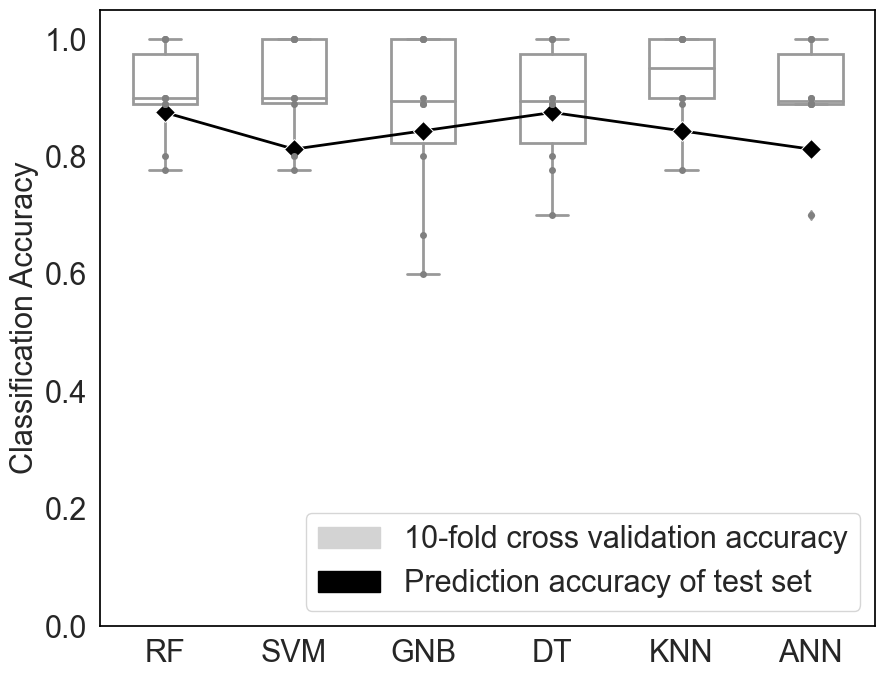

In [123]:
# Set a seaborn theme for aesthetics
sns.set_theme(style="whitegrid")
# Set figure size and resolution
plt.figure(figsize=(10, 8), dpi=100)

# Prepare data for boxplot
box_data = []
scatter_data = []
for i, model in enumerate(models_names):
    for value in cv_values[i]:
        box_data.append({'Model': model, 'Score': value, 'Type': 'CV Score'})
    # box_data.append({'Model': model, 'Score': test_accs[i], 'Type': 'Test Set Accuracy'})
    scatter_data.append({'Model': model, 'Score': test_accs[i]})
    

df = pd.DataFrame(box_data)
scatter_df = pd.DataFrame(scatter_data)

# Box plot for CV scores
sns.boxplot(x='Model', y='Score', data=df[df['Type'] == 'CV Score'], color='white', width=0.5, linewidth=2)
sns.stripplot(x='Model', y='Score', data=df[df['Type'] == 'CV Score'], color='gray', size=5, jitter=False)
sns.lineplot(x='Model', y='Score', data=scatter_df, color='black', marker="D", markersize=10, linewidth=2)

# Label the x-axis with model names
plt.xticks(fontsize=22)
# plt.xticks(rotation=20)
plt.yticks(fontsize=22)

plt.ylim(0, 1.05)
plt.ylabel('Classification Accuracy', fontsize=22)
plt.xlabel('', fontsize=14)

# Set title
# plt.title('Machine Learning Models Accuracy Score', fontsize=14)
box_patch = mpatches.Patch(color='lightgray', label=f'{cv}-fold cross validation accuracy')
scatter_patch = mpatches.Patch(color='black', label='Prediction accuracy of test set')
plt.legend(handles=[box_patch, scatter_patch], fontsize=22, loc='lower right')
plt.grid(False)

# Set the color for all four box lines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Set the background color as pure white
ax.set_facecolor('white')

# Show the plot
# plt.title(orchard+': SWP Prediction ', fontsize=20)
plt.savefig('../figures/'+orchard+'AccScore.png',bbox_inches='tight',dpi=300)
plt.show()


ROC-AUC

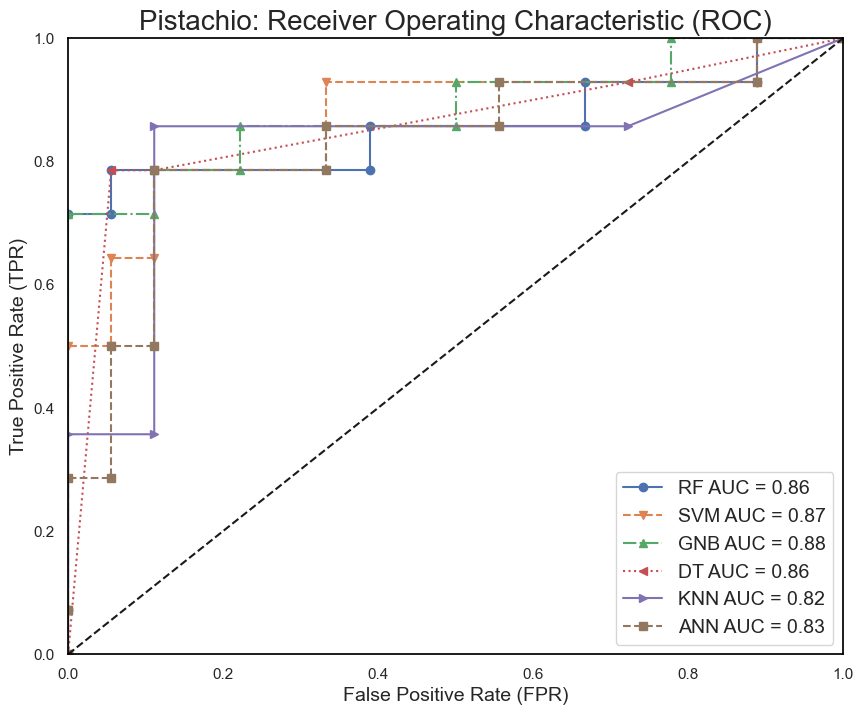

In [95]:
# Set the overall theme
sns.set_theme(style="white")

# Create a new figure
plt.figure(figsize=(10, 8), dpi=100)

# calculate the fpr and tpr for all thresholds of the classification
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
for prob, model_name, marker, linestyle in zip(model_probs, models_names, markers, linestyles):
    fpr, tpr, threshold = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'{model_name} AUC = %0.2f' % roc_auc, marker=marker, linestyle=linestyle)

# Title and labels
plt.title(orchard+': Receiver Operating Characteristic (ROC)', fontsize=20)
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)

# Set the color for all four box lines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Set the background color as pure white
ax.set_facecolor('white')

# Remove grid
plt.grid(False)

# Show the plot
plt.savefig('../figures/'+orchard+'_ROC.png',dpi=300)
plt.show()


Confusion Matrix

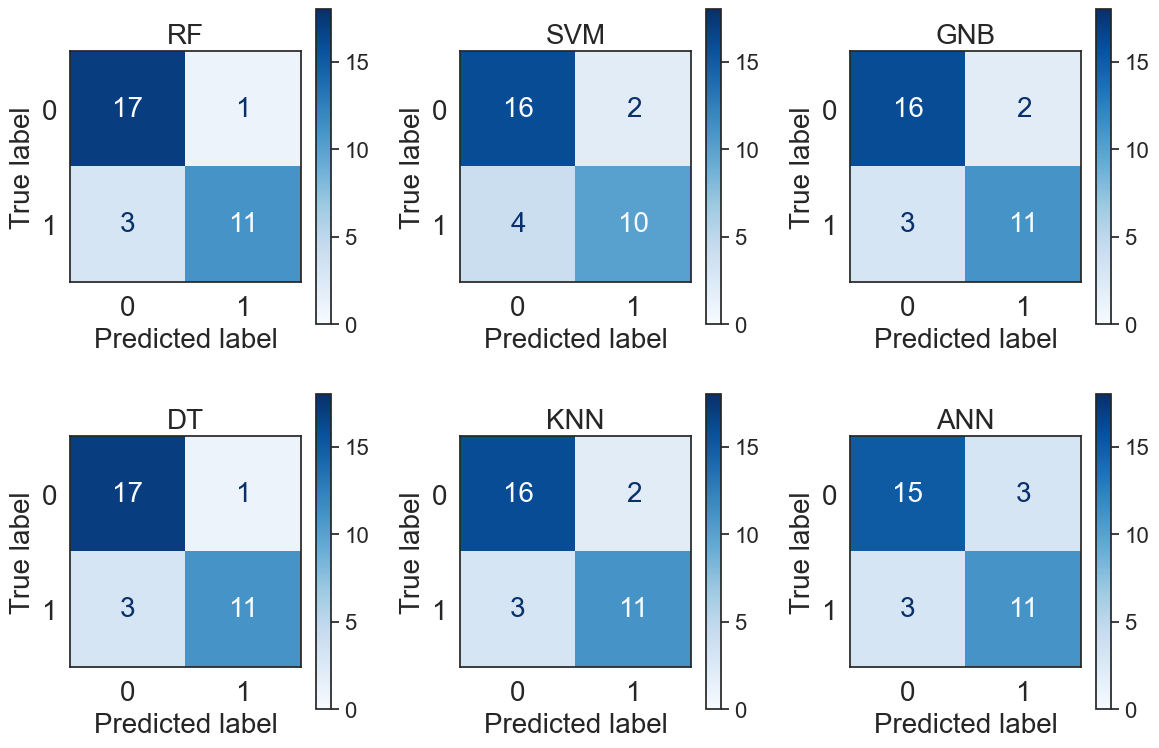

In [115]:
def plot_confusion_matrices(models, models_names, X_test, y_test, nrows=2, ncols=3):
    """Plots confusion matrices for all models."""
    # Create subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), dpi=100)

    # Iterate over models and corresponding axes
    for i, (model, name, ax) in enumerate(zip(models, models_names, axs.flatten())):
        # Make predictions
        y_pred = model.predict(X_test)
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        # Create confusion matrix display
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp = disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation='horizontal')
        # Set colorbar limits
        disp.im_.colorbar.remove()
        disp.im_ = ax.imshow(cm, cmap='Blues', vmin=0, vmax=18)
        cbar = fig.colorbar(disp.im_, ax=ax)
        cbar.ax.tick_params(labelsize=16)
        # Add a label to the upper left corner of each subplot
        # ax.text(0.02, 0.98, f"{ascii_lowercase[i]})", transform=ax.transAxes, color='white',
        #         size=20, weight='bold', ha='left', va='top')
        # Set title for subplot
        ax.set_title('{}'.format(name), size=20)
        # Remove grid for subplot
        ax.grid(False)

        # Set the font size for labels and tick labels
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)

    # If there are more subplots than models, hide the extra subplots
    if len(models) < len(axs.flatten()):
        for ax in axs.flatten()[len(models):]:
            ax.remove()

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()
    # Show the figure
    plt.savefig('../figures/' + orchard + '_confusionM.png', bbox_inches='tight', dpi=300)
    plt.show()


# Call the function with the required parameters
plot_confusion_matrices(models, models_names, X_test, y_test)


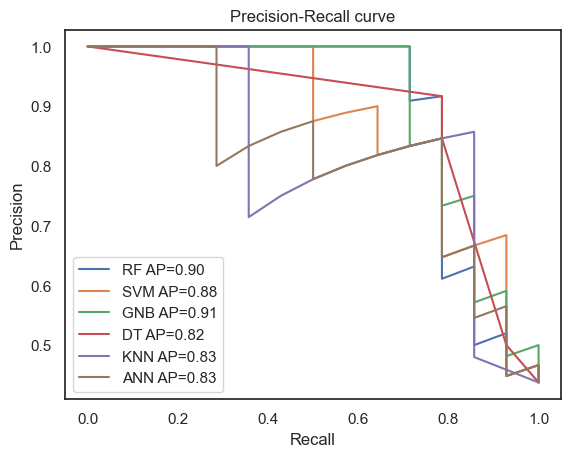

In [97]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

for prob, name in zip(model_probs, models_names):
    precision, recall, _ = precision_recall_curve(y_test, prob)
    avg_precision = average_precision_score(y_test, prob)
    plt.plot(recall, precision, label=f'{name} AP={avg_precision:0.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('Precision-Recall curve')
plt.show()

In [98]:
# from sklearn.model_selection import learning_curve

# def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None):
#     if axes is None:
#         _, axes = plt.subplots(1, 1)

#     axes.set_title(title)

#     if ylim is not None:
#         axes.set_ylim(*ylim)
#     axes.set_xlabel("Training examples")
#     axes.set_ylabel("Score")

#     train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs)

#     train_scores_mean = np.mean(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
    
#     axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
#     axes.legend(loc="best")

#     return plt

# for model, name in zip(models, models_names):
#     plot_learning_curve(model, name, X, y, cv=cv)


2-Feature RF

c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Students\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, b

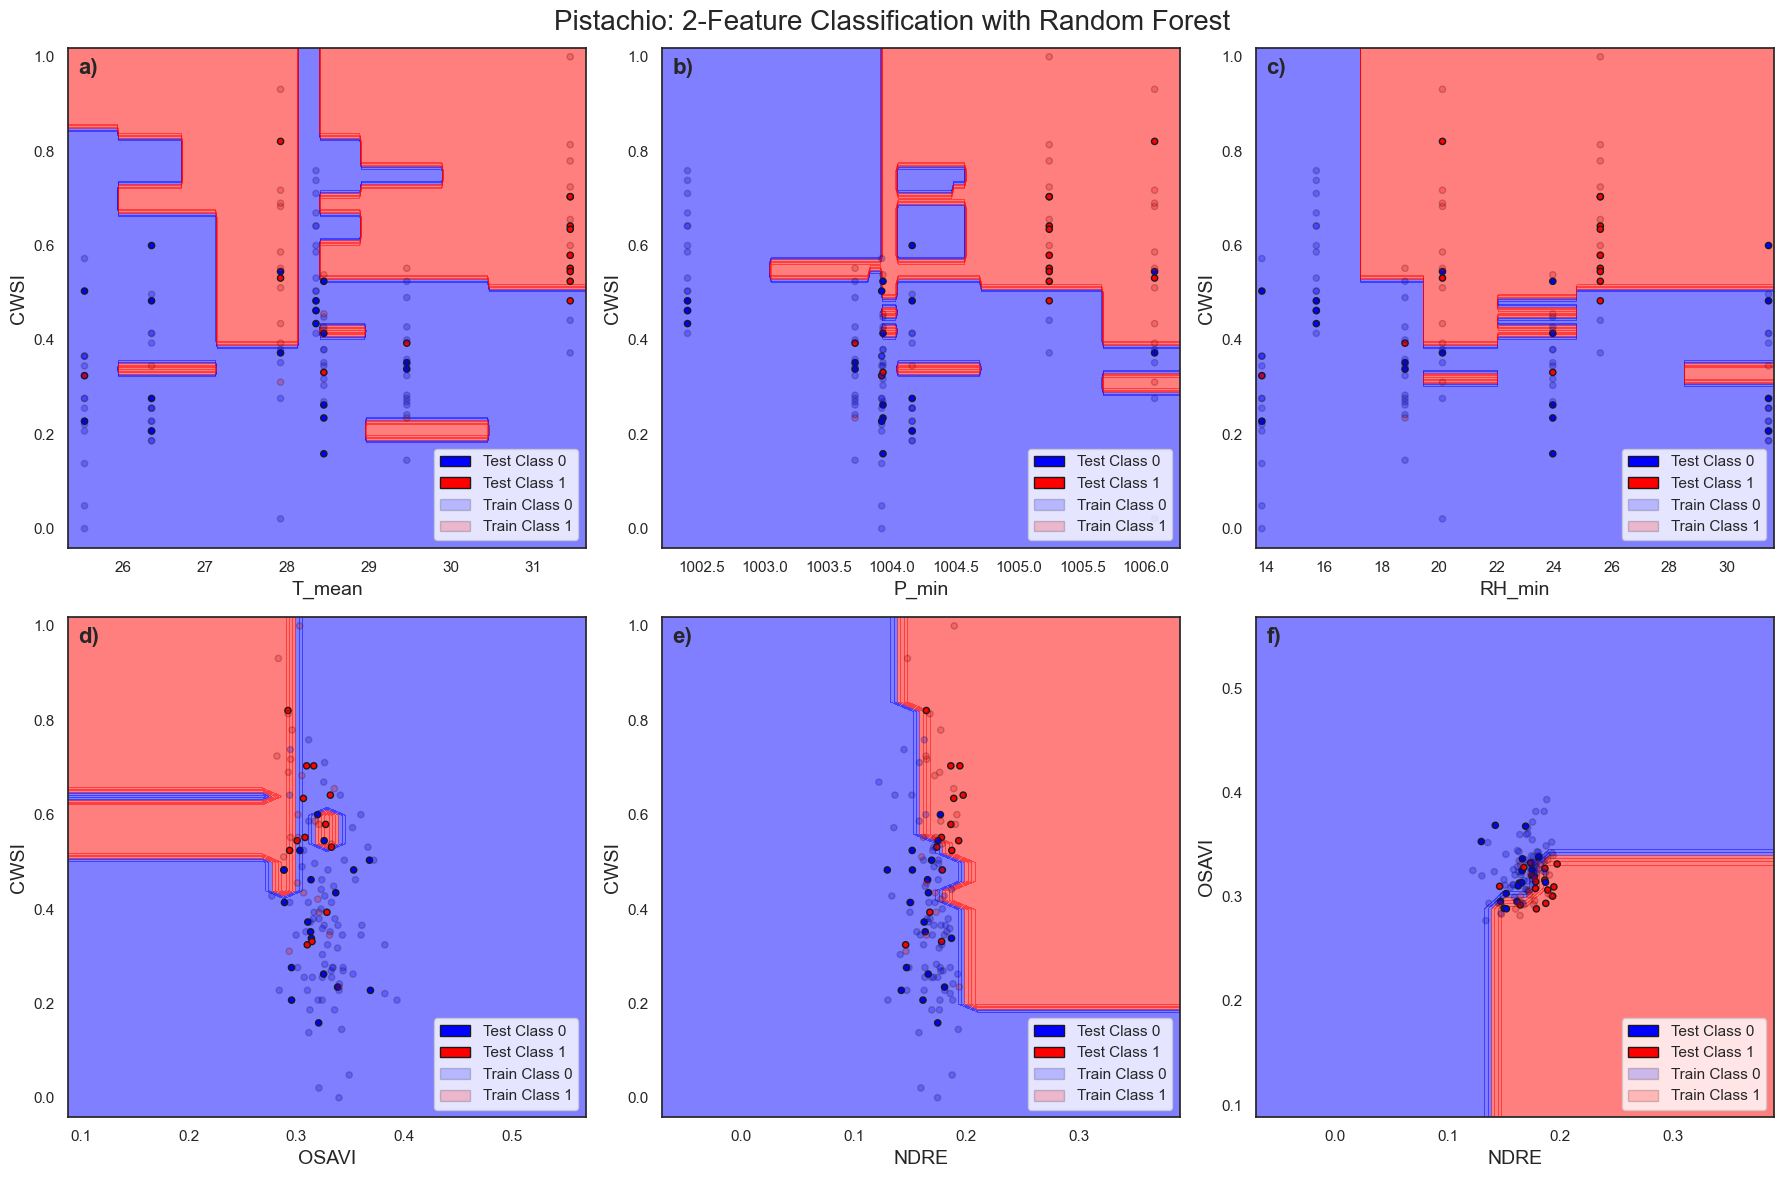

In [99]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_decision_boundaries(model, X_train, X_test, y_train, y_test, index_pairs):
    n_plots = len(index_pairs)
    nrows = 2  # 2 rows
    ncols = 3  # 3 columns

    # Define the plot colors
    colors = ('blue', 'red')
    cmap = ListedColormap(colors)

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6), dpi=100)
    fig.suptitle(orchard+': 2-Feature Classification with Random Forest', fontsize=20)
    # If there's only one plot, axs is not a 2D list
    if n_plots == 1:
        axs = [[axs]]

    for i, (index1, index2) in enumerate(index_pairs):
        ax = axs[i // ncols][i % ncols]
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])

        feature1 = X_train.columns[index1]  # get the feature name
        feature2 = X_train.columns[index2]  # get the feature name

        # Subset the dataset to include only these two features
        X_train_subset = X_train[[feature1, feature2]]

        pipeline.fit(X_train_subset, y_train)

        # Create a meshgrid for our plot
        x_min, x_max = X_test[feature1].min() - 0.2, X_test[feature1].max() + 0.2
        y_min, y_max = X_test[feature2].min() - 0.2, X_test[feature2].max() + 0.2
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        # Predict on the meshgrid
        Z = pipeline.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary
        ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

        # Plot also the training points
        ax.scatter(X_test[feature1], X_test[feature2], c=y_test, cmap=cmap, alpha=1, edgecolor='k', s=20)
        ax.set_xlabel(feature1,fontsize=14)
        ax.set_ylabel(feature2,fontsize=14)
        ax.grid(False)

            # Plot the training points
        # ax.scatter(X_train_subset[feature1], X_train_subset[feature2], c=y_train, cmap=ListedColormap(('lightblue', 'lightcoral')), edgecolor='k', s=20)
        ax.scatter(X_train_subset[feature1], X_train_subset[feature2], c=y_train, cmap=cmap, alpha=0.25, edgecolor='k', s=20)
        # ...
        
        # Define legend elements
        # Define legend elements
        legend_elements = [Patch(facecolor='blue', edgecolor='k', label='Test Class 0'),
                        Patch(facecolor='red', edgecolor='k', label='Test Class 1'),
                        Patch(facecolor='blue', edgecolor='k', label='Train Class 0', alpha=0.2),
                        Patch(facecolor='red', edgecolor='k', label='Train Class 1', alpha=0.2)]

        # Add legend to subplot
        ax.legend(handles=legend_elements, loc='lower right')


    for i, (index1, index2) in enumerate(index_pairs):
        ax = axs[i // ncols][i % ncols]
        
        # Add a label to the upper left corner of each subplot
        ax.text(0.02, 0.98, f"{ascii_lowercase[i]})", transform=ax.transAxes, 
                size=16, weight='bold', ha='left', va='top')

    plt.tight_layout()

    plt.savefig('../figures/'+orchard+'_2dRF.png',dpi=300)
    plt.show()

# Call the function with the required parameters
index_pairs = [(0, 3), (1, 3), (2, 3),(4,3),(5,3),(5,4)]  # replace with your chosen pairs of indices

# Instantiate a new RandomForestClassifier

new_rfc = RandomForestClassifier()
valid_params = new_rfc.get_params().keys()
trained_params = rfc.get_params()
filtered_params = {param_name: param_value for param_name, param_value in trained_params.items() if param_name in valid_params}
new_rfc.set_params(**filtered_params)

# Call the function
plot_decision_boundaries(new_rfc, X_train, X_test, y_train, y_test, index_pairs)

Feature Importances

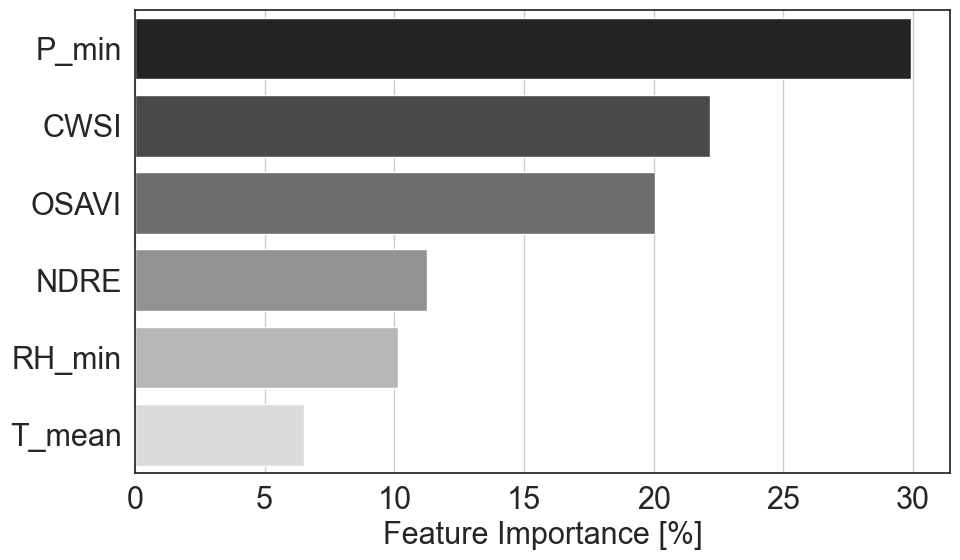

In [122]:
def plot_feature_importance(importances, feature_names):
    # Create a DataFrame with importances and corresponding feature names
    feature_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sort the DataFrame based on importance
    feature_imp = feature_imp.sort_values('Importance', ascending=False)

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 6),dpi=100)

    # Create a bar plot
    sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='gray')
    plt.yticks(fontsize=22)
    plt.xticks(fontsize=22)

    # Set the title and labels
    # plt.title(orchard+': Importance of Features \n', size=20)
    plt.xlabel('Feature Importance [%]', size=22)
    plt.ylabel('', size=22)
    plt.tight_layout()
    plt.grid(axis='x')
    plt.savefig('../figures/'+orchard+'_rankings.png',bbox_inches='tight',dpi=300)
    plt.show()


# Here is how you can use this function
plot_feature_importance(importances*100, rf_feature)